In [1]:
# pip install --user ipykernel
# python -m ipykernel install --user --name=myenv
import csv
import tqdm
import click
import logging
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

from string import digits

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F

seed = 42
epochs = 20
batch_size = 32
learning_rate = 1e-3
context_frames = 10
sequence_length = 20
lookback = sequence_length

context_epochs = 20
context_batch_size = 1
context_learning_rate = 1e-3
context_data_length = 20

valid_train_split = 0.8  # precentage of train data from total
test_train_split = 0.9  # precentage of train data from total

torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#  use gpu if available


In [2]:
class BatchGenerator:
    def __init__(self, data_dir, logger):
        self.data_dir = data_dir
        data_map = []
        with open(data_dir + 'map.csv', 'r') as f:  # rb
            reader = csv.reader(f)
            for row in reader:
                data_map.append(row)

        if len(data_map) <= 1: # empty or only header
            logger.error("No file map found")
            exit()

        self.data_map = data_map

    def load_full_data(self):
        dataset_train = FullDataSet(self.data_dir, self.data_map, type_="train")
        dataset_valid = FullDataSet(self.data_dir, self.data_map, type_="valid")
        dataset_test = FullDataSet(self.data_dir, self.data_map, type_="test")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
        return train_loader, valid_loader, test_loader

    def load_context_data(self):
        dataset_train = ContextDataSet(self.data_dir, self.data_map, type_="train")
        dataset_valid = ContextDataSet(self.data_dir, self.data_map, type_="valid")
        dataset_test = ContextDataSet(self.data_dir, self.data_map, type_="valid")
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=context_batch_size, shuffle=True)
        valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=context_batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=context_batch_size, shuffle=False)
        return train_loader, valid_loader, test_loader

    
class ContextDataSet():
    def __init__(self, data_dir, data_map, type_="train"):
        context_file_names = []
        context_data = []
        for index, value in enumerate(data_map[1:]):  # ignore header
            if value[8] not in context_file_names:
                context_file_names.append(value[8])
                context_data.append(np.load(data_dir + value[8]))

        if type_ == "train":
            self.samples = context_data[0:int(len(context_data)*test_train_split)]
        elif type_ == "valid":
            self.samples = context_data[int(len(context_data)*(valid_train_split)):int(len(context_data)*test_train_split)]
        elif type_ == "test":
            self.samples = context_data[int(len(context_data)*test_train_split):-1]
        data_map = None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        return(self.samples[idx])

    
class FullDataSet():
    def __init__(self, data_dir, data_map, type_="train"):
        dataset_full = []
        for index, value in enumerate(data_map[1:]):  # ignore header
            state = np.float32(np.load(data_dir + '/' + value[4]))
            dataset_full.append([np.load(data_dir + value[8]),
                                 np.float32(np.load(data_dir + '/' + value[2])),
                                 np.float32(np.load(data_dir + '/' + value[3])),
                                 np.asarray([state[0] for i in range(0, len(state))])])
        if type_ == "train":
            self.samples = dataset_full[0:int(len(dataset_full)*test_train_split)]
        elif type_ == "valid":
            self.samples = dataset_full[int(len(dataset_full)*(valid_train_split)):int(len(dataset_full)*test_train_split)]
        elif type_ == "test":
            self.samples = dataset_full[int(len(dataset_full)*test_train_split):-1]

        data_map = None

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        return(self.samples[idx])

data_dir = '/home/user/Robotics/Data_sets/slip_detection/vector_normalised_002/'
logger = logging.getLogger(__name__)

BG = BatchGenerator(data_dir, logger)
print("done")

done


In [3]:
class ContextAutoEncoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        logger = kwargs["logger"]
        logger.info("Auto Encoder Initialised")

        self.encoder_hidden1_layer = nn.Linear(in_features=kwargs["input_shape"], out_features=128)
        self.encoder_hidden2_layer = nn.Linear(in_features=128, out_features=74)
        self.encoder_output_layer = nn.Linear(in_features=74, out_features=48)

        self.decoder_hidden1_layer = nn.Linear(in_features=48, out_features=74)
        self.decoder_hidden2_layer = nn.Linear(in_features=74, out_features=128)
        self.decoder_output_layer = nn.Linear(in_features=128, out_features=kwargs["output_shape"])

    def forward(self, features):
        activation1 = self.encoder_hidden1_layer(features)
        activation1 = torch.relu(activation1)

        activation2 = self.encoder_hidden2_layer(activation1)
        activation2 = torch.relu(activation2)

        code = self.encoder_output_layer(activation2)
        code = torch.sigmoid(code)

        activation1 = self.decoder_hidden1_layer(code)
        activation1 = torch.relu(activation1)

        activation2 = self.decoder_hidden2_layer(activation1)
        activation2 = torch.relu(activation2)

        activation3 = self.decoder_output_layer(activation2)
        reconstructed = torch.sigmoid(activation3)

        return reconstructed

    def encoder(self, features):
        activation1 = self.encoder_hidden1_layer(features)
        activation1 = torch.relu(activation1)

        activation2 = self.encoder_hidden2_layer(activation1)
        activation2 = torch.relu(activation2)

        code = self.encoder_output_layer(activation2)
        code = torch.sigmoid(code)

        return code


In [4]:
class FullModel(nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.lstm1 = nn.LSTM(48, 48).to(device)  # tactile
        self.lstm2 = nn.LSTM(48, 48).to(device)  # context
        self.fc1 = nn.Linear(96, 48)  # tactile + context
        self.lstm3 = nn.LSTM(6, 6).to(device)  # pos_vel
        self.fc2 = nn.Linear(54, 48)  # tactile + pos_vel
        self.lstm4 = nn.LSTM(48, 48).to(device)  # tactile, context, robot

    def forward(self, tactiles, actions, context):
        state = actions[0]
        state.to(device)
        batch_size__ = tactiles.shape[1]
        outputs = []
        hidden1 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
        hidden2 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
        hidden3 = (torch.rand(1,batch_size__,6).to(device), torch.rand(1,batch_size__,6).to(device))
        hidden4 = (torch.rand(1,batch_size__,48).to(device), torch.rand(1,batch_size__,48).to(device))
        for index, (sample_tactile, sample_action, sample_context) in enumerate(zip(tactiles.squeeze(), actions.squeeze(), context)):
            sample_context.to(device)
            sample_tactile.to(device)
            sample_action.to(device)
            # 2. Run through lstm:
            if index > context_frames-1:
                out1, hidden1 = self.lstm1(out6, hidden1)
                out2, hidden2 = self.lstm2(sample_context.unsqueeze(0), hidden2)
                context_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
                out3 = self.fc1(context_and_tactile.unsqueeze(0).cpu().detach())

                out4, hidden3 = self.lstm3(sample_action.unsqueeze(0), hidden3)
                context_and_tactile_and_robot = torch.cat((out3.squeeze().to(device), out4.squeeze()), 1)

                out5 = self.fc2(context_and_tactile_and_robot.unsqueeze(0).cpu().detach())
                out6, hidden4 = self.lstm4(out5.to(device), hidden4)
                outputs.append(out6.squeeze())
            else:
                out1, hidden1 = self.lstm1(sample_tactile.unsqueeze(0), hidden1)
                out2, hidden2 = self.lstm2(sample_context.unsqueeze(0), hidden2)
                context_and_tactile = torch.cat((out2.squeeze(), out1.squeeze()), 1)
                out3 = self.fc1(context_and_tactile.unsqueeze(0).cpu().detach())

                out4, hidden3 = self.lstm3(sample_action.unsqueeze(0), hidden3)
                context_and_tactile_and_robot = torch.cat((out3.squeeze().to(device), out4.squeeze()), 1)

                out5 = self.fc2(context_and_tactile_and_robot.unsqueeze(0).cpu().detach())
                out6, hidden4 = self.lstm4(out5.to(device), hidden4)

        return torch.stack(outputs)


In [5]:
class ModelTrainer:
    def __init__(self, logger, data_dir):
        self.data_dir = data_dir
        ### Train the context model:
        self.context_model = ContextAutoEncoder(input_shape=(context_epochs*48), output_shape=(context_epochs*48), logger=logger).to(device)
        self.context_optimizer = optim.Adam(self.context_model.parameters(), lr=learning_rate)  # create an optimizer object || Adam optimizer with learning rate 1e-3
        self.context_criterion = nn.L1Loss()  # mean-squared error loss
        self.train_context_loader, self.valid_context_loader, self.test_context_loader = BG.load_context_data()

        ### Train the LSTM chain:
        self.train_full_loader, self.valid_full_loader, self.test_full_loader = BG.load_full_data()
        self.full_model = FullModel()
        self.criterion = nn.L1Loss()
        self.optimizer = optim.Adam(self.full_model.parameters(), lr=learning_rate)

    def train_full_model(self):
        plot_training_loss = []
        plot_validation_loss = []
        previous_val_mean_loss = 1.0
        early_stop_clock = 0
        progress_bar = tqdm.tqdm(range(0, epochs), total=(epochs*len(self.train_full_loader)))
        mean_test = 0
        for epoch in progress_bar:
            loss = 0
            losses = 0.0
            for index, batch_features in enumerate(self.train_full_loader):
                # 1. Calculate context model: 
                context_data_list = []
                for context_data in batch_features[0]:
                    context = context_data.view(-1, context_epochs*48).to(device)
                    context = self.context_model.encoder(context)  # [0]
                    context_list = []
                    for sequence in range(sequence_length):
                        context_list.append(context.cpu().detach().numpy())
                    context_data_list.append(context_list)
                context_data_list = np.asarray(context_data_list).squeeze()
                context_data_list = torch.FloatTensor(context_data_list)

                # 2. Reshape data and send to device:
                context = context_data_list.permute(1,0,2).to(device)                
                tactile = batch_features[1].permute(1,0,2).to(device)
                action = batch_features[2].permute(1,0,2).to(device)
                state = batch_features[3].permute(1,0,2).to(device)

                tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action, context=context) # Step 3. Run our forward pass.
                self.optimizer.zero_grad()
                loss = self.criterion(tactile_predictions.to(device), tactile[context_frames:])
                loss.backward()
                self.optimizer.step()

                losses += loss.item()
                if index:
                    mean = losses / index
                else:
                    mean = 0
                progress_bar.set_description("epoch: {}, ".format(epoch) + "loss: {:.4f}, ".format(float(loss.item())) + "mean loss: {:.4f}, ".format(mean))
                progress_bar.update()
            plot_training_loss.append(mean)

            val_losses = 0.0
            val_loss = 0.0
            with torch.no_grad():
                for index__, batch_features in enumerate(self.valid_full_loader):
                    # 1. Calculate context model: 
                    context_data_list = []
                    for context_data in batch_features[0]:
                        context = context_data.view(-1, context_epochs*48).to(device)
                        context = self.context_model.encoder(context)  # [0]
                        context_list = []
                        for sequence in range(sequence_length):
                            context_list.append(context.cpu().detach().numpy())
                        context_data_list.append(context_list)
                    context_data_list = np.asarray(context_data_list).squeeze()
                    context_data_list = torch.FloatTensor(context_data_list)

                    # 2. Reshape data and send to device:
                    context = context_data_list.permute(1,0,2).to(device)   
                    tactile = batch_features[1].permute(1,0,2).to(device)
                    action = batch_features[2].permute(1,0,2).to(device)
                    state = batch_features[3].permute(1,0,2).to(device)

                    tactile_predictions = self.full_model.forward(tactiles=tactile, actions=action, context=context)  # Step 3. Run our forward pass.
                    self.optimizer.zero_grad()
                    val_loss = self.criterion(tactile_predictions.to(device), tactile[context_frames:])
                    val_losses += val_loss.item()

            print("Validation mean loss: {:.4f}, ".format(val_losses / index__))
            plot_validation_loss.append(val_losses / index__)
            if previous_val_mean_loss < val_losses / index__:
                early_stop_clock +=1
                if early_stop_clock == 3:
                    print("Early stopping")
                    break
            else:
                early_stop_clock = 0
            previous_val_mean_loss = val_losses / index__

        plt.plot(plot_training_loss, c="r", label="train loss MAE")
        plt.plot(plot_validation_loss, c='b', label="val loss MAE")
        plt.legend(loc="upper right")

    def train_context_model(self):
        prev_val_mean_loss = 1.0
        early_stop_clock = 0
        for context_epoch in range(context_epochs):
            train_loss = 0
            for index__, batch_features in enumerate(self.train_context_loader):
                self.context_optimizer.zero_grad()  # reset the gradients back to zero PyTorch accumulates gradients on subsequent backward passes
                outputs = self.context_model(batch_features.view(-1, context_epochs*48).to(device))  # compute reconstructions
                train_loss = self.context_criterion(outputs, batch_features[0].view(-1, context_epochs*48).to(device))  # compute training reconstruction loss
                train_loss.backward()  # compute accumulated gradients
                self.context_optimizer.step()  # perform parameter update based on current gradients
                train_loss += train_loss.item()  # add the mini-batch training loss to epoch loss
            train_loss = train_loss / index__  # compute the epoch training loss
            print("Train loss = {:.8f}".format(train_loss.item()))
            val_losses = 0
            with torch.no_grad():
                for index__, batch_features in enumerate(self.valid_context_loader):
                    valid_examples = batch_features.view(-1, context_epochs*48).to(device)
                    reconstruction = self.context_model(valid_examples)
                    val_loss = self.context_criterion(reconstruction, batch_features[0].view(-1, context_epochs*48).to(device))
                    val_losses += val_loss.item()
            val_loss = val_losses / index__  # compute the epoch training loss
            print("validation loss = {:.8f}".format(val_loss)) # display the epoch training loss

            if val_loss > prev_val_mean_loss:
                if early_stop_clock == 3:
                    print("early_stopping") 
                    break
                else:
                    early_stop_clock += 1
            else:
                early_stop_clock = 0
            prev_test_loss = val_loss

        test_losses = 0
        with torch.no_grad():
            for index__, batch_features in enumerate(self.test_context_loader):
                valid_examples = batch_features.view(-1, context_epochs*48).to(device)
                reconstruction = self.context_model(valid_examples)
                test_loss = self.context_criterion(reconstruction, batch_features[0].view(-1, context_epochs*48).to(device))
                test_losses += test_loss.item()
        test_loss = test_losses / index__  # compute the epoch training loss
        print("test loss = {:.8f}".format(test_loss)) # display the epoch training loss


MT = ModelTrainer(logger, data_dir)
print("done")

done


Train loss = 0.00175910
validation loss = 0.04535219
Train loss = 0.00079434
validation loss = 0.04331769
Train loss = 0.00087571
validation loss = 0.04379320
Train loss = 0.00054362
validation loss = 0.04299527
Train loss = 0.00082434
validation loss = 0.04310690
Train loss = 0.00173252
validation loss = 0.04269149
Train loss = 0.00090089
validation loss = 0.04202811
Train loss = 0.00064779
validation loss = 0.04427631
Train loss = 0.00161632
validation loss = 0.04229075
Train loss = 0.00059938
validation loss = 0.04312236
Train loss = 0.00084105
validation loss = 0.04225549
Train loss = 0.00159367
validation loss = 0.04229628
Train loss = 0.00259762
validation loss = 0.04248358
Train loss = 0.00063690
validation loss = 0.04257527
Train loss = 0.00072596
validation loss = 0.04193809
Train loss = 0.00056254
validation loss = 0.04292760
Train loss = 0.00341876
validation loss = 0.04277858
Train loss = 0.00067256
validation loss = 0.04211112


  0%|          | 0/14340 [00:00<?, ?it/s]

Train loss = 0.00048656
validation loss = 0.04106440
Train loss = 0.00063880
validation loss = 0.04105396
test loss = 0.04105396


epoch: 1, loss: 0.0223, mean loss: 0.0333, :   5%|▌         | 721/14340 [00:34<49:59,  4.54it/s]  

Validation mean loss: 0.0243, 


epoch: 2, loss: 0.0199, mean loss: 0.0294, :  10%|█         | 1436/14340 [01:09<1:05:16,  3.29it/s]

Validation mean loss: 0.0173, 


epoch: 3, loss: 0.0124, mean loss: 0.0172, :  15%|█▌        | 2157/14340 [01:43<37:25,  5.43it/s]  

Validation mean loss: 0.0135, 


epoch: 4, loss: 0.0094, mean loss: 0.0148, :  20%|██        | 2873/14340 [02:17<56:30,  3.38it/s]

Validation mean loss: 0.0104, 


epoch: 5, loss: 0.0102, mean loss: 0.0139, :  25%|██▌       | 3592/14340 [02:49<35:46,  5.01it/s]

Validation mean loss: 0.0114, 


epoch: 6, loss: 0.0091, mean loss: 0.0133, :  30%|███       | 4308/14340 [03:22<44:37,  3.75it/s]

Validation mean loss: 0.0103, 


epoch: 7, loss: 0.0098, mean loss: 0.0123, :  35%|███▌      | 5025/14340 [03:55<41:10,  3.77it/s]

Validation mean loss: 0.0088, 


epoch: 8, loss: 0.0079, mean loss: 0.0111, :  40%|████      | 5742/14340 [04:28<38:37,  3.71it/s]

Validation mean loss: 0.0084, 


epoch: 9, loss: 0.0088, mean loss: 0.0126, :  45%|████▌     | 6459/14340 [05:01<35:52,  3.66it/s]

Validation mean loss: 0.0084, 


epoch: 10, loss: 0.0081, mean loss: 0.0099, :  50%|█████     | 7177/14340 [05:33<23:26,  5.09it/s]

Validation mean loss: 0.0080, 


epoch: 11, loss: 0.0074, mean loss: 0.0092, :  55%|█████▌    | 7894/14340 [06:06<21:52,  4.91it/s]

Validation mean loss: 0.0081, 


epoch: 12, loss: 0.0111, mean loss: 0.0128, :  60%|██████    | 8611/14340 [06:39<19:26,  4.91it/s]

Validation mean loss: 0.0087, 


epoch: 13, loss: 0.0089, mean loss: 0.0118, :  65%|██████▌   | 9328/14340 [07:12<17:22,  4.81it/s]

Validation mean loss: 0.0077, 


epoch: 14, loss: 0.0111, mean loss: 0.0116, :  70%|███████   | 10045/14340 [07:45<15:07,  4.74it/s]

Validation mean loss: 0.0083, 


epoch: 15, loss: 0.0082, mean loss: 0.0111, :  75%|███████▌  | 10762/14340 [08:18<12:00,  4.96it/s]

Validation mean loss: 0.0084, 


epoch: 15, loss: 0.0071, mean loss: 0.0079, :   0%|          | 15/14340 [08:50<140:42:26, 35.36s/it]

Validation mean loss: 0.0097, 
Early stopping
done


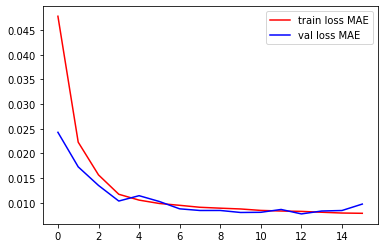

In [6]:
MT.train_context_model()
MT.train_full_model()
print("done")

In [87]:
data_dir = '/home/user/Robotics/Data_sets/slip_detection/vector_normalised_002/'
data_map = []
with open(data_dir + 'map.csv', 'r') as f:  # rb
    reader = csv.reader(f)
    for row in reader:
        data_map.append(row)

if len(data_map) <= 1: # empty or only header
    logger.error("No file map found")
    exit()

data_map = data_map[int(len(data_map)*test_train_split):-1]  # split into just test data
dataset_full = []
current_experiment = [int(data_map[0][-2][i]) for i in range(len(data_map[0][-2])) if data_map[0][-2][i].isdigit()]
experiment = []
for index, value in enumerate(data_map[1:]):  # ignore header
    if current_experiment == [int(value[-2][i]) for i in range(len(value[-2])) if value[-2][i].isdigit()]:
        state = np.float32(np.load(data_dir + '/' + value[4]))
        experiment.append([np.load(data_dir + value[8]),
                         np.float32(np.load(data_dir + '/' + value[2])),
                         np.float32(np.load(data_dir + '/' + value[3])),
                         np.asarray([state[0] for i in range(0, len(state))])])
    else:
        dataset_full.append(experiment)
        experiment = []
        current_experiment = [int(value[-2][i]) for i in range(len(value[-2])) if value[-2][i].isdigit()]
        state = np.float32(np.load(data_dir + '/' + value[4]))
        experiment.append([np.load(data_dir + value[8]),
                         np.float32(np.load(data_dir + '/' + value[2])),
                         np.float32(np.load(data_dir + '/' + value[3])),
                         np.asarray([state[0] for i in range(0, len(state))])])
        
# create data loader:
class DataSample():
    def __init__(self, data_sample):
        self.samples = data_sample

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,idx):
        return(self.samples[idx])

DataSampleSet = []
for data_sample in dataset_full:
    dataset_test = DataSample(data_sample)
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=11, shuffle=False)
    DataSampleSet.append(test_loader)
print("done")

done


In [133]:
import copy
context_model = MT.context_model 
model = MT.full_model
data_dir = MT.data_dir

# test model on the full test sample:
criterion1 = nn.L1Loss()
criterion2 = nn.MSELoss()
tactile_predictions_full = []
tactile_groundtruth_full = []
with torch.no_grad():
    for test_number, test_loader in enumerate(DataSampleSet):
        tactile_predictions = []
        tactile_groundtruth = []
        test_lossesMAE = 0.0
        test_lossesMSE = 0.0
        experiments_pred = []
        experiments_gt = []
        current_experiment = 0
        for index__, batch_features in enumerate(test_loader):
            # 1. Calculate context model: 
            context_data_list = []
            for context_data in batch_features[0]:
                context = context_data.view(-1, context_epochs*48).to(device)
                context = context_model.encoder(context)  # [0]
                context_list = []
                for sequence in range(sequence_length):
                    context_list.append(context.cpu().detach().numpy())
                context_data_list.append(context_list)
            context_data_list = np.asarray(context_data_list).squeeze()
            context_data_list = torch.FloatTensor(context_data_list)

            # 2. Reshape data and send to device:
            context = context_data_list.permute(1,0,2).to(device)
            tactile = batch_features[1].permute(1,0,2).to(device)
            action = batch_features[2].permute(1,0,2).to(device)
            state = batch_features[3].permute(1,0,2).to(device)

            tp = model.forward(tactiles=tactile, actions=action, context=context)
            tactile_predictions.append(tp)  # Step 3. Run our forward pass.
            tactile_groundtruth.append(tactile[context_frames:])

            # calculate losses
            test_lossMAE = criterion1(tp.to(device), tactile[context_frames:])
            test_lossesMAE += test_lossMAE.item()
            test_lossMSE = criterion2(tp.to(device), tactile[context_frames:])
            test_lossesMSE += test_lossMSE.item()
        
        print("test " + str(test_number) + " loss MAE(L1): ", str(test_lossesMAE / index__))
        print("test " + str(test_number) + " loss MSE: ", str(test_lossesMSE / index__))
            
        tactile_predictions_full.append(tactile_predictions)
        tactile_groundtruth_full.append(tactile_groundtruth)


test 0 loss MAE(L1):  0.00935440487228334
test 0 loss MSE:  0.0003514136380025385
test 1 loss MAE(L1):  0.014353152979830546
test 1 loss MSE:  0.001357236054900568
test 2 loss MAE(L1):  0.01430346496636048
test 2 loss MSE:  0.0010737365851127834
test 3 loss MAE(L1):  0.010874902674307426
test 3 loss MSE:  0.0006490458727057558
test 4 loss MAE(L1):  0.00792294810526073
test 4 loss MSE:  0.00011294113784587305
test 5 loss MAE(L1):  0.0155922821102043
test 5 loss MSE:  0.001228316691413056
test 6 loss MAE(L1):  0.008511491868968891
test 6 loss MSE:  0.00012965946149526408
test 7 loss MAE(L1):  0.02403225397158946
test 7 loss MSE:  0.0011066021834267303


In [120]:
# calculate tactile values for full sample:
time_step_to_test_t1 = 0    # [batch_set, prediction frames(t1->tx)(6), batch_size, features(48)]
time_step_to_test_t9 = 5
predicted_data_t1 = []
predicted_data_t9 = []
groundtruth_data_t1 = []
groundtruth_data_t9 = []
experiment_to_test = 0
# for tactile_predictions in enumerate(tactile_predictions_full):
tactile_predictions = tactile_predictions_full[experiment_to_test]
tactile_groundtruth = tactile_groundtruth_full[experiment_to_test]
for index, batch_set in enumerate(tactile_predictions):
#     if index in [i for i in range(3,6)]:
    for batch in range(0, len(batch_set[0])):
        prediction_values = batch_set[time_step_to_test_t1][batch]
        predicted_data_t1.append(prediction_values)
        gt_values_t1 = tactile_groundtruth[index][time_step_to_test_t1][batch]
        groundtruth_data_t1.append(gt_values_t1)

        prediction_values_ = batch_set[time_step_to_test_t9][batch]
        predicted_data_t9.append(prediction_values_)
        gt_values_t9 = tactile_groundtruth[index][time_step_to_test_t9][batch]
        groundtruth_data_t9.append(gt_values_t9)
print(len(predicted_data_t1))
print("done")

315
done


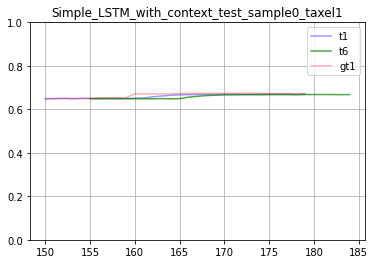

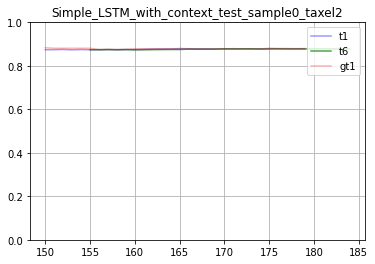

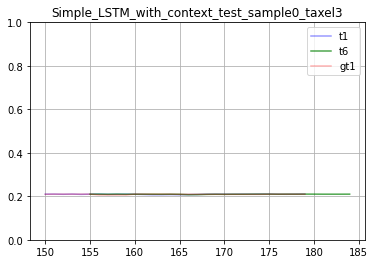

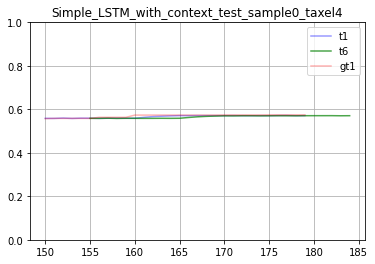

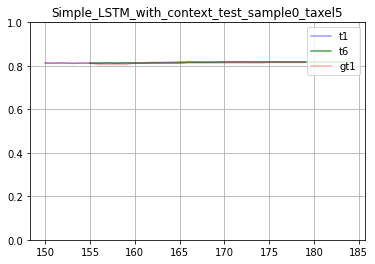

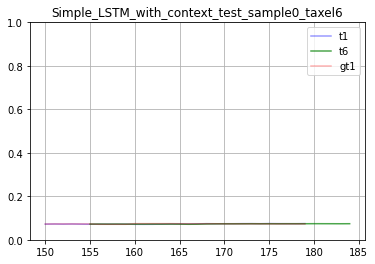

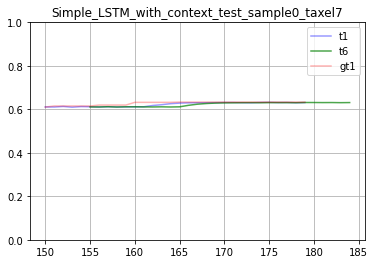

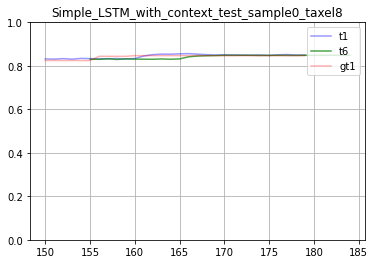

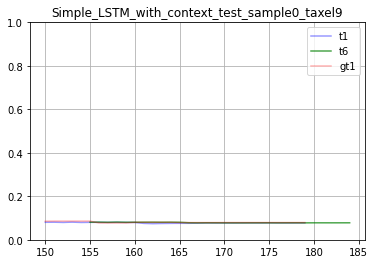

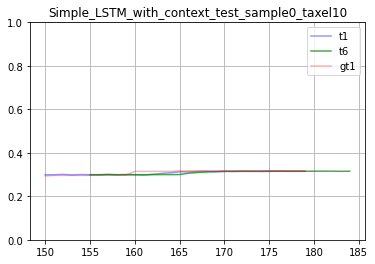

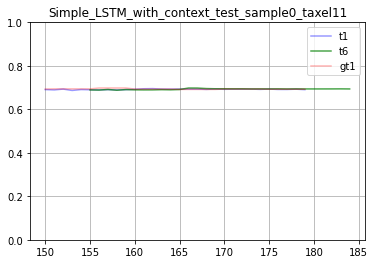

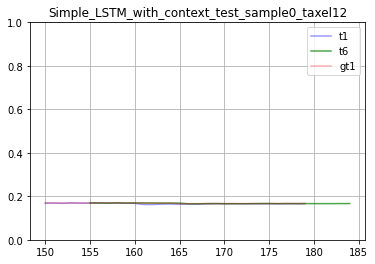

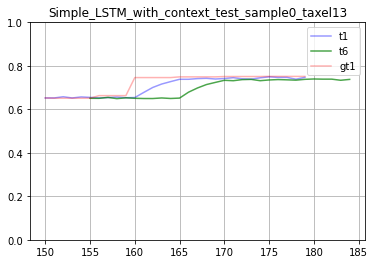

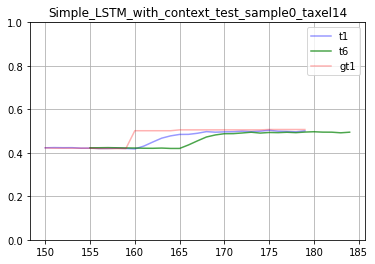

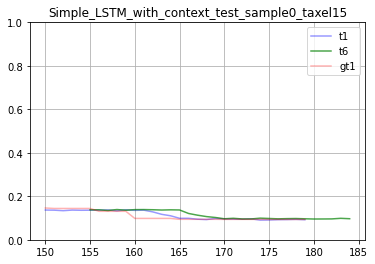

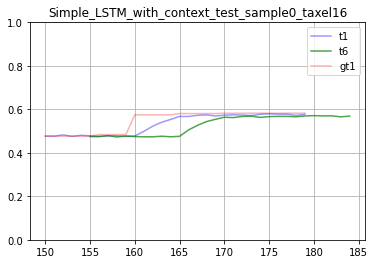

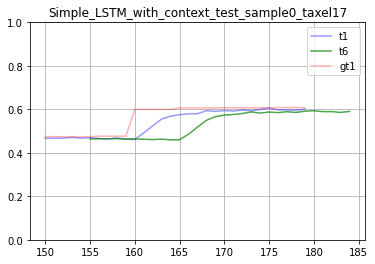

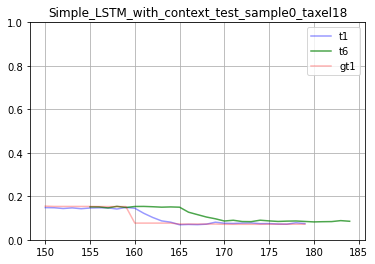

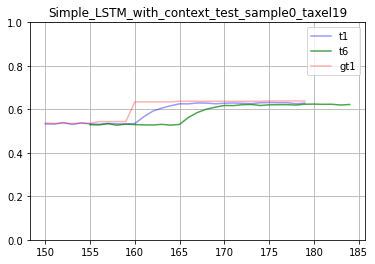

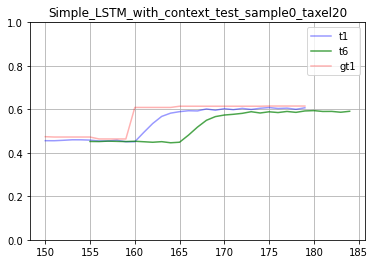

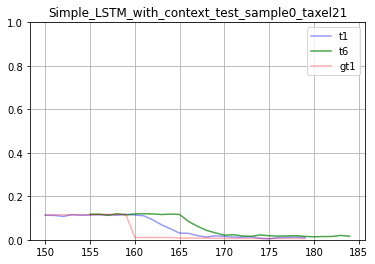

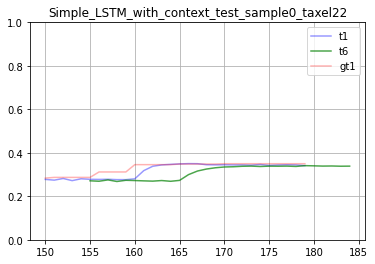

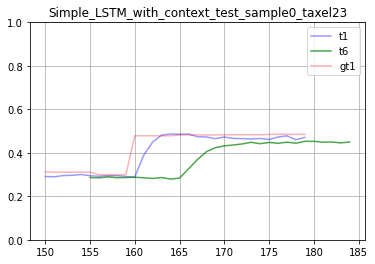

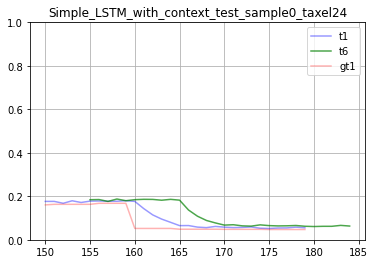

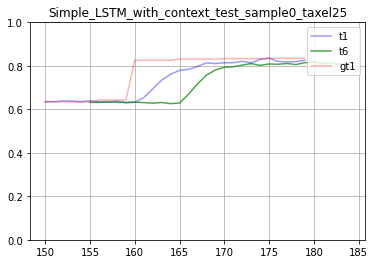

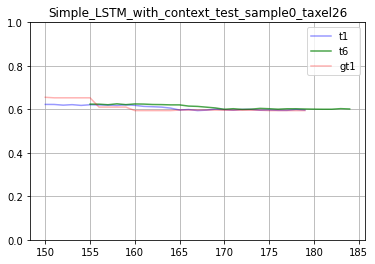

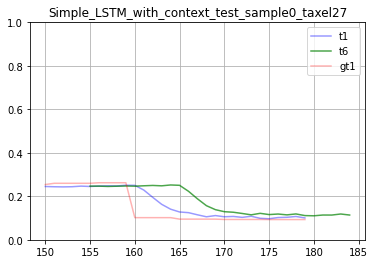

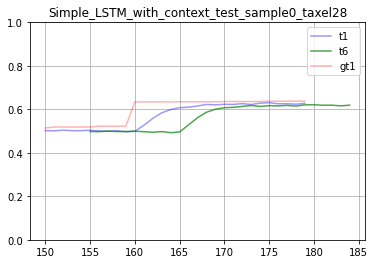

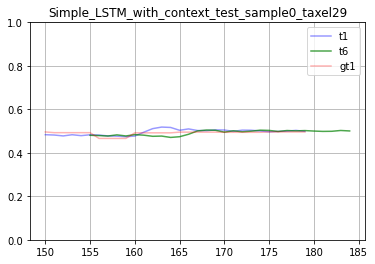

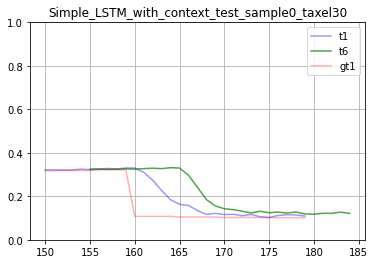

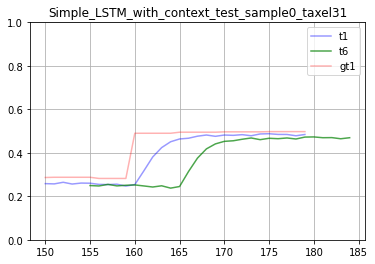

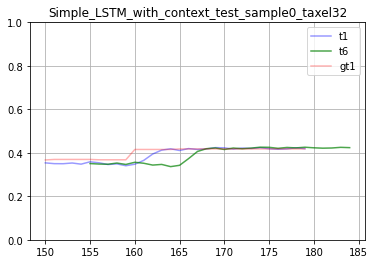

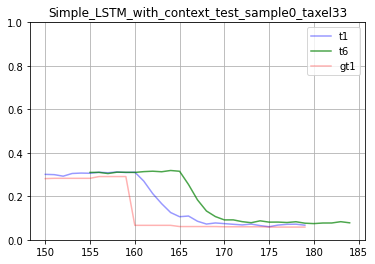

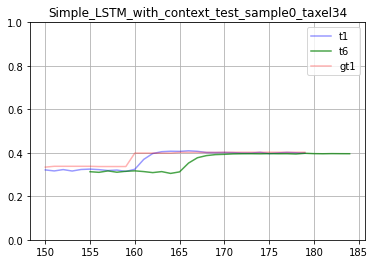

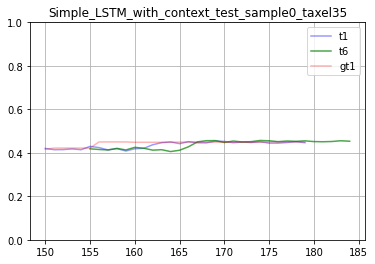

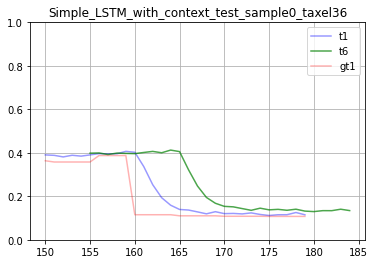

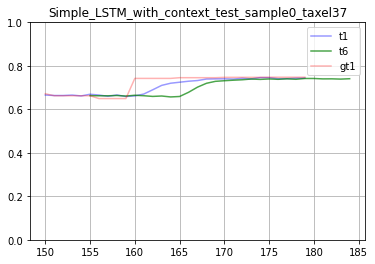

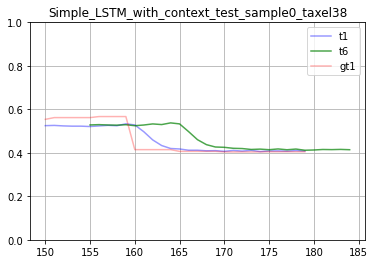

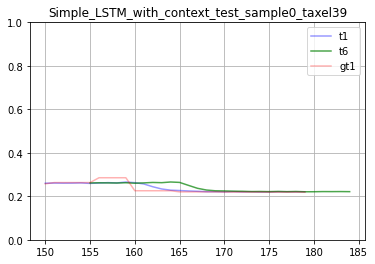

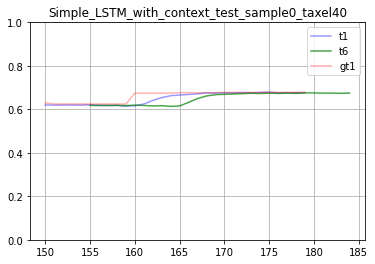

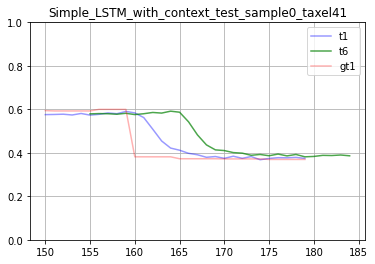

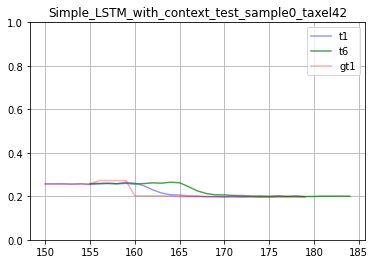

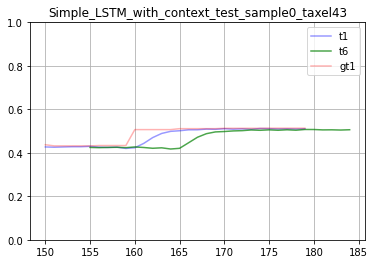

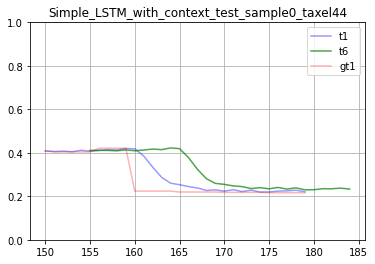

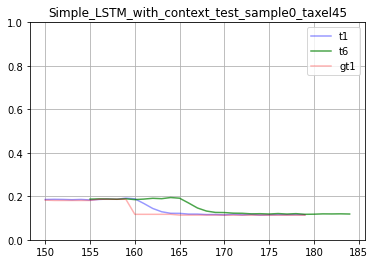

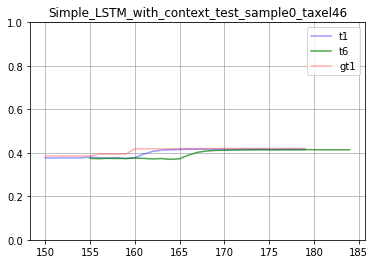

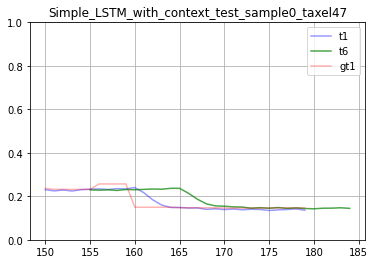

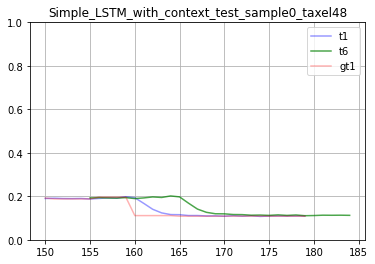

In [134]:
# test data
index = 0
titles = ["sheerx", "sheery", "normal"]
for j in range(3):
    for i in range(16):
        groundtruth_taxle_t1 = []
        groundtruth_taxle_t9 = []
        predicted_taxel = []
        predicted_taxel_t1 = []
        predicted_taxel_t9 = []
        start = 150  # 0
        end = 180  # len(predicted_data_t1)
        for k in range(start, end):#len(predicted_data_t1)):#):#(310, 325):#len(predicted_data_t1)):  # add in length of context data
            predicted_taxel_t1.append(predicted_data_t1[k][index].cpu().detach().numpy())
            predicted_taxel_t9.append(predicted_data_t9[k][index].cpu().detach().numpy())
            groundtruth_taxle_t1.append(groundtruth_data_t1[k][index].cpu().detach().numpy())
            groundtruth_taxle_t9.append(groundtruth_data_t9[k][index].cpu().detach().numpy())

        index += 1
        plt.title("Simple_LSTM_with_context_test_sample" + str(experiment_to_test) + "_taxel" + str(index))
        plt.plot([i for i in range(start,end)], predicted_taxel_t1, alpha=0.4, c="b", label="t1")
        plt.plot([i for i in range(start+time_step_to_test_t9, end+time_step_to_test_t9)], predicted_taxel_t9, alpha=0.7, c="g", label="t6")
        plt.plot([i for i in range(start,end)], groundtruth_taxle_t1, alpha=0.3, c="r", label="gt1")
        plt.ylim([0, 1])
        plt.grid()
        plt.legend(loc="upper right")
        plt.savefig('/home/user/Robotics/slip_detection_model/images/Simple_LSTM_with_context_new_data/simple_model_test_sample_' + str(index) + '.png')
        plt.show()